[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Dataset URL: https://www.kaggle.com/datasets/balaka18/email-spam-classification-dataset-csv
License(s): ODbL-1.0
  0% 0.00/1.66M [00:00<?, ?B/s]
100% 1.66M/1.66M [00:00<00:00, 103MB/s]

Removed 253 columns:
Single and double char strings and stopwords removed: ['the', 'to', 'and', 'for', 'of', 'a', 'you', 'in', 'on', 'is', 'this', 'i', 'be', 'that', 'will', 'have', 'with', 'your', 'at', 'we']...
Iteration 1, loss = 0.17356370
Validation score: 0.975845
Iteration 2, loss = 0.06139820
Validation score: 0.968599
Iteration 3, loss = 0.05901148
Validation score: 0.978261
Iteration 4, loss = 0.03345436
Validation score: 0.983092
Iteration 5, loss = 0.03063476
Validation score: 0.975845
Iteration 6, loss = 0.02246986
Validation score: 0.983092
Iteration 7, loss = 0.01881743
Validation score: 0.983092
Iteration 8, loss = 0.01639174
Validation score: 0.985507
Iteration 9, loss = 0.01461137
Validation score: 0.983092
Iteration 10, loss = 0.01327341
Validation score: 0.983092
Iteration 11, loss =

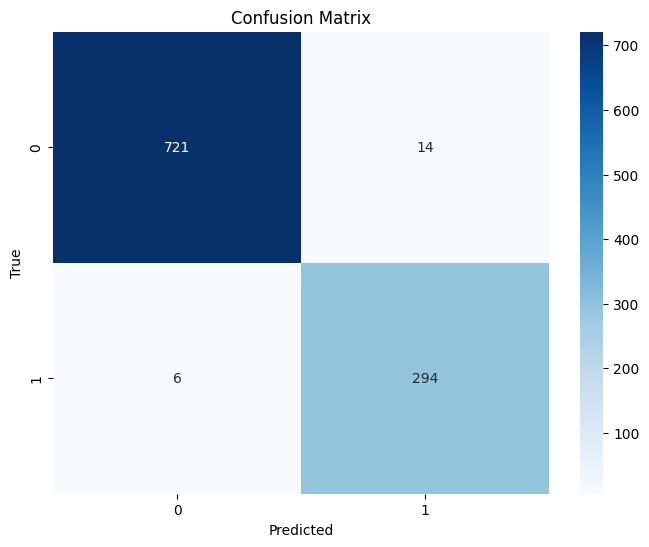

Sample Predictions:
--------------------------------------------------

Text: Meeting tomorrow at 10:00 am to discuss the project timeline. Please bring your reports.
Prediction: NOT SPAM
Confidence: 98.81%
Spam Probability: 1.19%
Not Spam Probability: 98.81%
--------------------------------------------------

Text: CONGRATULATIONS! You've won $1,000,000! Click here to claim your PRIZE now!!!
Prediction: SPAM
Confidence: 83.20%
Spam Probability: 83.20%
Not Spam Probability: 16.80%
--------------------------------------------------

Text: The quarterly report is attached. Please review and provide feedback by Friday.
Prediction: SPAM
Confidence: 78.36%
Spam Probability: 78.36%
Not Spam Probability: 21.64%
--------------------------------------------------

Text: Buy now! Limited time offer! 90% OFF! Act fast! Don't miss out!!!
Prediction: SPAM
Confidence: 86.10%
Spam Probability: 86.10%
Not Spam Probability: 13.90%
--------------------------------------------------

Text: Dear team, fol

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPCl

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import nltk
import zipfile
import joblib

# Download stopwords from NLTK
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# 1. Data Preparation

# Download and extract the dataset from kaggle
dataset_name = 'balaka18/email-spam-classification-dataset-csv'

!kaggle datasets download -d {dataset_name}

with zipfile.ZipFile("email-spam-classification-dataset-csv.zip", 'r') as zip_ref:
    zip_ref.extractall('email-spam-classification-dataset-csv')


# Load data
df = pd.read_csv(f"email-spam-classification-dataset-csv/emails.csv")
df.head()

X = df.drop(columns=['Prediction','Email No.'])
y = df['Prediction']


# Remove stopwords and words made up of 1-2 characters (eg."a",'th') as their apperance in the emails is not correlated to it being Spam or Non-spam
columns_to_drop = [col for col in X.columns if
                  len(col) <= 2 or
                  col.lower() in stop_words]

X = X.drop(columns=columns_to_drop)


print(f"\nRemoved {len(columns_to_drop)} columns:")
print(f"Single and double char strings and stopwords removed: {columns_to_drop[:20]}...")


# 2. Split the data into test and training sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Init and train the MLP
mlp = MLPClassifier(
    hidden_layer_sizes=(75, 25),
    activation='relu',
    solver='adam',
    alpha=0.001,
    learning_rate_init=0.01,
    batch_size=32,
    max_iter=100,
    early_stopping=True,
    random_state=42,
    verbose=True
)

mlp.fit(X_train, y_train)

# 4. Evaluate the model

# Make predictions
y_pred = mlp.predict(X_test)

# Save model and features names for later use
joblib.dump(mlp, 'spam_classifier_freq.joblib')
joblib.dump(list(X.columns), 'feature_names.joblib')

# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

# F1 score
f1 = f1_score(y_test, y_pred)
print(f"\nF1 Score: {f1:.3f}")

# Load the saved model and feature names
loaded_model = joblib.load('spam_classifier_freq.joblib')
feature_names = joblib.load('feature_names.joblib')

def prepare_text_features(text):
    """
    Convert input text to feature vector for inference
    """
    features = {word: 0 for word in feature_names}

    words = text.lower().split()
    for word in words:
        if word in features:
            features[word] += 1

    return [features[word] for word in feature_names]

def predict_text(text, model):
    """
    Predict if a text is spam
    """
    features = prepare_text_features(text)

    prediction = model.predict([features])[0]
    probabilities = model.predict_proba([features])[0]

    result = {
        'prediction': 'SPAM' if prediction == 1 else 'NOT SPAM',
        'confidence': max(probabilities) * 100,
        'spam_probability': probabilities[1] * 100,
        'not_spam_probability': probabilities[0] * 100,
        'text': text
    }

    return result

# Sample emails for demo purposes
sample_texts = [
    "Meeting tomorrow at 10:00 am to discuss the project timeline. Please bring your reports.",
    "CONGRATULATIONS! You've won $1,000,000! Click here to claim your PRIZE now!!!",
    "The quarterly report is attached. Please review and provide feedback by Friday.",
    "Buy now! Limited time offer! 90% OFF! Act fast! Don't miss out!!!",
    "Dear team, following up on the action items from yesterday's meeting."
]

print("Sample Predictions:")
print("-" * 50)
for text in sample_texts:
    result = predict_text(text, loaded_model)
    print(f"\nText: {text}")
    print(f"Prediction: {result['prediction']}")
    print(f"Confidence: {result['confidence']:.2f}%")
    print(f"Spam Probability: {result['spam_probability']:.2f}%")
    print(f"Not Spam Probability: {result['not_spam_probability']:.2f}%")
    print("-" * 50)